In [1]:
import voltron 
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import pandas as pd

import argparse
import datetime
import gpytorch
from botorch.models import SingleTaskGP
from botorch.optim.fit import fit_gpytorch_torch
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.means import ConstantMean, LinearMean, Mean
from gpytorch.kernels import SpectralMixtureKernel, MaternKernel, RBFKernel, ScaleKernel
from voltron.train_utils import LearnGPCV, TrainVolModel, TrainVoltMagpieModel, TrainBasicModel
from voltron.models import VoltMagpie
from voltron.means import LogLinearMean, EWMAMean

from voltron.rollout_utils import GeneratePrediction, Rollouts
from voltron.data import make_ticker_list, DataGetter, GetStockHistory


Warning no robinhood utils.


In [2]:
def EWMA(y, k):
    alpha = 2./(k + 1)
    conv = torch.nn.Conv1d(1, 1, kernel_size=k)
    wghts = alpha * (1-alpha)**(torch.arange(k-1, -1, -1))
    conv.weight.data = wghts.unsqueeze(0).unsqueeze(0)/wghts.sum()
    conv.bias.data = torch.zeros(1)    

    conv = conv.to(y.device)
    res = y[..., 0].unsqueeze(-1) * torch.ones(*y.shape[:-1], k).to(y.device)
    padded_px = torch.cat((res, y), dim=-1)
    batch_dim = y.shape[-2] if y.ndim > 1 else 1
    padded_px = padded_px.reshape(batch_dim, 1, -1)
    # print("padded_px shape = ", padded_px.shape)
    with torch.no_grad():
        ma = conv(padded_px).squeeze()
        
    # print("ma shape = ", ma.shape)
    return ma.type(torch.FloatTensor)

In [3]:
# dat = pd.read_csv("https://www.ncei.noaa.gov/data/local-climatological-data/access/2003/01001099999.csv")
dat = pd.read_csv("https://www.ncei.noaa.gov/pub/data/uscrn/products/subhourly01/2020/CRNS0101-05-2020-OR_Riley_10_WSW.txt",
                 header=None)
dat = dat.iloc[:700]
wind = []
for row, vec in dat.iterrows():
    wind.append(float(vec.item().split()[-2]))

In [4]:
ntrain = 500

train_x = torch.arange(ntrain).float()/365
train_y = torch.FloatTensor(wind[:ntrain]) + 1
test_x = torch.arange(ntrain, len(wind)).float()/365
test_y = torch.FloatTensor(wind[ntrain:]) + 1

# if torch.cuda.is_available():
#     use_cuda = True,
#     train_x, train_y = train_x.cuda(), train_y.cuda()
#     test_x, test_y = test_x.cuda(), test_y.cuda()

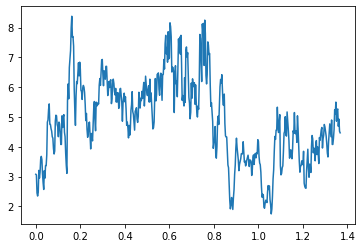

In [23]:
plt.plot(train_x, train_y)

In [147]:
log_returns =train_y[1:] - train_y[:-1]
vol_est = log_returns.std() * 0.25

## Mean Reverting Moving Average

In [150]:
class MeanRevertingEMAMean(Mean):
    def __init__(self, train_x, train_y, k=20, theta=0.5):
        super().__init__()
        self.k = k
        self.theta = theta
        self.alpha = 2./(self.k + 1)
        self.train_x = train_x
        self.train_y = train_y
        self.latent_mean = train_y.mean()
        
    def forward(self, x):
        ema = EWMA(self.train_y, self.k).to(self.train_x.device)
        ema[..., 1:] -= self.theta * (ema[..., :-1] - self.latent_mean)
        if x.numel() == 1:
            res = ema[..., -1].unsqueeze(0)
            return res.type(torch.FloatTensor).to(self.train_x.device)
        elif torch.equal(x.squeeze(), self.train_x.squeeze()):
            return ema[..., :-1].type(torch.FloatTensor).to(self.train_x.device)
        else:
            return ema.type(torch.FloatTensor).to(self.train_x.device)
        
        

def Rollouts(train_x, train_y, test_x, mean_func, vol, nsample=50):
    
    ntest = test_x.numel()
    samples = torch.zeros(nsample, ntest)
    samples[:, 0] = mean_func(test_x[0]) + torch.randn(nsample) * vol
    
    train_stack_y = train_y[1:].repeat(nsample, 1)
    
    for idx in range(1, ntest):
        stack_y = torch.cat((train_stack_y, 
                             samples[:, :idx].to(train_stack_y.device)), -1)
        rolling_x = torch.cat((train_x, test_x[:idx]))
        mean_func.train_y = stack_y
        mean_func.train_x = rolling_x
        
        samples[:, idx] = mean_func(test_x[idx]) + torch.randn(nsample) * vol
        
    return samples

In [151]:
mean = MeanRevertingEMAMean(train_x, train_y, k=100, theta=0.5)
ema_mean = EWMAMean(train_x, train_y, k=20)
start_mean = mean(train_x)
start_ema_mean = ema_mean(train_x)

In [152]:
samples = Rollouts(train_x, train_y, test_x, mean, vol_est, nsample=4)
ma_samples = Rollouts(train_x, train_y, test_x, ema_mean, vol_est, nsample=4)

In [153]:
mean(test_x).shape

torch.Size([4, 699])

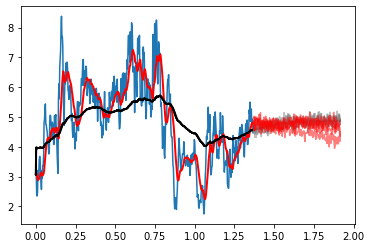

In [154]:
plt.plot(train_x, train_y)
plt.plot(train_x, start_mean, color='k', lw=2.)
plt.plot(train_x, start_ema_mean, color='r', lw=2.)
plt.plot(torch.cat((train_x, test_x))[:-1], mean(test_x).T, color='k')
# plt.plot(torch.cat((train_x, test_x))[:-1], ema_mean(test_x).T, color='r', ls='--')
# plt.plot(train_x, mean(torch.cat((train_x, test_x)[:-1])
# plt.plot(train_x, ema_mean(train_x))
plt.plot(test_x, samples.T, color='gray', alpha=0.5);
plt.plot(test_x, ma_samples.T, color='red', alpha=0.5);

In [155]:
mean(test_x[0])

tensor([[4.8789, 4.8737, 4.8776, 4.8820]])

In [50]:
mrma = ma.clone()
mrma[1:] -= 0.5*(mrma[:-1] - train_y.mean())

In [51]:
mr_func = MeanRevertingEMAMean(train_x, train_y, k=200)
mr_mean = mr_func(train_x)

ma_func = EWMAMean(train_x, train_y, k=200)
ma_mean = ma_func(train_x)

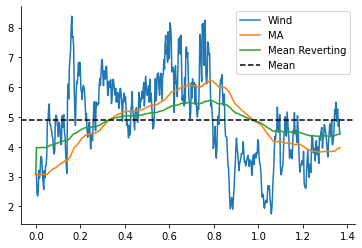

In [52]:
plt.plot(train_x[:-1], train_y, label="Wind")
plt.plot(train_x[:-1], ma_mean, label="MA")
plt.plot(train_x[:-1], mr_mean, label="Mean Reverting")
plt.axhline(train_y.mean(), c='k', ls='--', label='Mean')
sns.despine()
plt.legend()

In [53]:
ntrain = 500

train_x = torch.arange(ntrain-1).float()/365
train_y = torch.FloatTensor(wind[:ntrain]) + 1
test_x = torch.arange(ntrain, len(wind)).float()/365
test_y = torch.FloatTensor(wind[ntrain:]) + 1

if torch.cuda.is_available():
    use_cuda = True,
    train_x, train_y = train_x.cuda(), train_y.cuda()
    test_x, test_y = test_x.cuda(), test_y.cuda()

In [54]:
with gpytorch.settings.max_cholesky_size(2000):
    vol = LearnGPCV(train_x, train_y, train_iters=200,
                        printing=True)
    vmod, vlh = TrainVolModel(train_x, vol, 
                              train_iters=200, printing=True)
    

/home/greg_b/miniconda3/envs/rpp/lib/python3.8/site-packages/gpytorch/utils/cholesky.py:38: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(


Iter 1/200 - Loss: 15.705
Iter 51/200 - Loss: 2.152
Iter 101/200 - Loss: 2.098
Iter 151/200 - Loss: 2.094
Iter 1/200 - Loss: 0.791
Iter 51/200 - Loss: 0.577
Iter 101/200 - Loss: 0.353
Iter 151/200 - Loss: 0.117


In [55]:
voltron, lh = TrainVoltMagpieModel(train_x, train_y[1:], 
                                   vmod, vlh, vol,
                                   printing=True, 
                                   train_iters=100,
                                   k=200, mean_func="meanrevert", theta=1.)

Iter 1/100 - Loss: 0.816
Iter 51/100 - Loss: -0.709


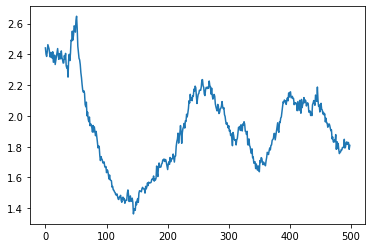

In [56]:
plt.plot(vol.cpu())

In [57]:
vmod.eval();
save_samples = Rollouts(train_x, train_y, test_x, voltron, 
                        nsample=10)

In [58]:
predictions = save_samples.exp().detach()

In [59]:
# test_y = torch.tensor(dat.HourlyWindSpeed.to_numpy()).float()[400:600] + 1

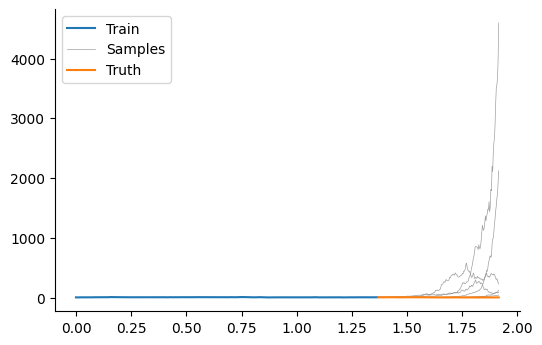

In [60]:
plt.figure(dpi=100)
plt.plot(train_x.cpu(), train_y[1:].cpu(), label="Train")
# plt.plot(test_x.cpu(), test_y.cpu())
plt.plot(test_x.cpu(), save_samples[0, :].detach().t().exp(), alpha=0.75, lw=0.5, color='gray', label="Samples")
plt.plot(test_x.cpu(), save_samples[:10, :].detach().t().exp(), alpha=0.75, lw=0.5, color='gray')
plt.plot(test_x.cpu(), test_y.cpu(), label='Truth')
# plt.fill_between(test_x.cpu(), predictions.mean(0).cpu() - 2 * predictions.std(0).cpu(),
#                  predictions.mean(0).cpu() + 2 * predictions.std(0).cpu(),
#                  color = "green", alpha = 0.2
#                 )
# plt.ylim((0, 100))
sns.despine()
plt.legend()

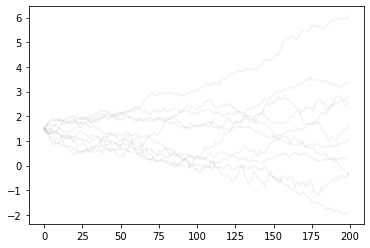

In [42]:
plt.plot(save_samples.detach().t(), color = "grey", alpha = 0.1)
# plt.ylim((0, 30))